# Train an anti-aliased U-net based GAN

## Imports and GPU identification

In [33]:
import tensorflow as tf
import os
from PIL import Image
from scipy import special
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.client import device_lib
from datetime import datetime

print(device_lib.list_local_devices())
print(tf.config.experimental.get_memory_info("/device:GPU:0")['current'])

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18238590235275771647
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4183621632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14663478106993549942
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
5376


## Test Keras convolution
Find out what the Keras convolution automatic zero paddings are for padding = "SAME", depending on the input size and kernel size. For skip connections it is important that the data stays centered spatially. These tests need not be run for the rest of the notebook to work.

In [34]:
print("Downsampling, even size input, even size kernel:")
print("Input:")
input_ = tf.ones((1, 8, 8, 1), dtype=tf.float32)
print(input_[0, :, :, 0].numpy())
print("Kernel:")
kernel = tf.ones((4, 4, 1, 1), dtype=tf.float32)
print(kernel[:, :, 0, 0].numpy())
print("Output of strides = 2, padding = 'SAME' convolution:")
conv = tf.nn.conv2d(input = input_, filters = kernel, strides = 2, padding = 'SAME')
print(conv[0, :, :, 0].numpy())
print("The output is properly centered.")
print("Output size = input size / 2")

print("\nDownsampling, odd size input, even size kernel:")
print("Input:")
input_ = tf.ones((1, 7, 7, 1), dtype=tf.float32)
print(input_[0, :, :, 0].numpy())
print("Kernel:")
kernel = tf.ones((4, 4, 1, 1), dtype=tf.float32)
print(kernel[:, :, 0, 0].numpy())
print("Output of strides = 2, padding = 'SAME' convolution:")
conv = tf.nn.conv2d(input = input_, filters = kernel, strides = 2, padding = 'SAME')
print(conv[0, :, :, 0].numpy())
print("Invalid output centering! Don't do this.")

print("\nDownsampling, even size input, odd size kernel:")
print("Input:")
input_ = tf.ones((1, 8, 8, 1), dtype=tf.float32)
print(input_[0, :, :, 0].numpy())
print("Kernel:")
kernel = tf.ones((3, 3, 1, 1), dtype=tf.float32)
print(kernel[:, :, 0, 0].numpy())
print("Output of strides = 2, padding = 'SAME' convolution:")
conv = tf.nn.conv2d(input = input_, filters = kernel, strides = 1, padding = 'SAME')
print(conv[0, :, :, 0].numpy())
print("Invalid output centering! Don't do this.")

print("\nDownsampling, odd size input, odd size kernel:")
print("Input:")
input_ = tf.ones((1, 9, 9, 1), dtype=tf.float32)
print(input_[0, :, :, 0].numpy())
print("Kernel:")
kernel = tf.ones((5, 5, 1, 1), dtype=tf.float32)
print(kernel[:, :, 0, 0].numpy())
print("Output of strides = 2, padding = 'SAME' convolution:")
conv = tf.nn.conv2d(input = input_, filters = kernel, strides = 1, padding = 'SAME')
print(conv[0, :, :, 0].numpy())
print("The output is properly centered.")
print("Output size = (input size + 1) / 2")

Downsampling, even size input, even size kernel:
Input:
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]
Kernel:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Output of strides = 2, padding = 'SAME' convolution:
[[ 9. 12. 12.  9.]
 [12. 16. 16. 12.]
 [12. 16. 16. 12.]
 [ 9. 12. 12.  9.]]
The output is properly centered.
Output size = input size / 2

Downsampling, odd size input, even size kernel:
Input:
[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
Kernel:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Output of strides = 2, padding = 'SAME' convolution:
[[ 9. 12. 12.  6.]
 [12. 16. 16.  8.]
 [12. 16. 16.  8.]
 [ 6.  8.  8.  4.]]
Invalid output centering! Don't do this.



In [35]:
print("Upsampling, any size input, even size kernel:")
print("Input:")
input_ = tf.ones((1, 4, 4, 1), dtype=tf.float32)
print(input_[0, :, :, 0].numpy())
tile = tf.constant([[0, 0], [0, 4]], dtype=tf.float32)
input_shape = input_.get_shape()
tiles = tf.reshape(tf.tile(tile, [input_shape[-3], input_shape[-2]]), (1, input_shape[-3]*2, input_shape[-2]*2, 1))
print("Diluted:")
diluted = tf.keras.layers.UpSampling2D(size = (2, 2), interpolation='nearest')(input_)*tiles
print(diluted[0, :, :, 0].numpy());
print("Kernel:")
kernel = tf.ones((4, 4, 1, 1), dtype=tf.float32)
print(kernel[:, :, 0, 0].numpy())
print("Output of strides = 1, padding = 'SAME' convolution:")
conv = tf.nn.conv2d(input = diluted, filters = kernel, strides = 1, padding = 'SAME')
print(conv[0, :, :, 0].numpy())
print("The output is properly centered.")
print("Output size = input size * 2")

print("\nUpsampling, any size input, odd size kernel:")
print("Input:")
input_ = tf.ones((1, 4, 4, 1), dtype=tf.float32)
print(input_[0, :, :, 0].numpy())
tile = tf.constant([[0, 0], [0, 4]], dtype=tf.float32)
input_shape = input_.get_shape()
tiles = tf.reshape(tf.tile(tile, [input_shape[-3], input_shape[-2]])[1:,1:], (1, input_shape[-3]*2 - 1, input_shape[-2]*2 - 1, 1))
print("Diluted:")
diluted = tf.keras.layers.UpSampling2D(size = (2, 2), interpolation='nearest')(input_)[:,1:,1:,:]*tiles
print(diluted[0, :, :, 0].numpy());
print("Kernel:")
kernel = tf.ones((3, 3, 1, 1), dtype=tf.float32)
print(kernel[:, :, 0, 0].numpy())
print("Output of strides = 1, padding = 'SAME' convolution:")
conv = tf.nn.conv2d(input = diluted, filters = kernel, strides = 1, padding = 'SAME')
print(conv[0, :, :, 0].numpy())
print("The output is properly centered.")
print("Output size = input size * 2 - 1")


Upsampling, any size input, even size kernel:
Input:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Diluted:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 4. 0. 4. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 4. 0. 4. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 4. 0. 4. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 4. 0. 4. 0. 4.]]
Kernel:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Output of strides = 1, padding = 'SAME' convolution:
[[ 4.  8.  8.  8.  8.  8.  8.  4.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 8. 16. 16. 16. 16. 16. 16.  8.]
 [ 4.  8.  8.  8.  8.  8.  8.  4.]]
The output is properly centered.
Output size = input size * 2

Upsampling, any size input, odd size kernel:
Input:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Diluted:
[[4. 0. 4. 0. 4. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0.]
 [4. 0. 4. 0. 4. 0. 4.]


## Circularly symmetric low-pass or anti-aliasing filter
Functions for generating a filter kernel with a parameterized cutoff frequency and kernel size

In [36]:
def circular_lowpass_kernel(omega_c, N):  # omega = cutoff frequency in radians (pi is max), N = horizontal size of the kernel, also its vertical size.
    with np.errstate(divide='ignore',invalid='ignore'):    
        kernel = np.fromfunction(lambda x, y: omega_c*special.j1(omega_c*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2))/(2*np.pi*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2)), [N, N])
    if N % 2:
        kernel[(N - 1)//2, (N - 1)//2] = omega_c**2/(4*np.pi)
    return kernel

def rotated_cosine_window(N):  # N = horizontal size of the targeted kernel, also its vertical size, must be odd.
    return np.fromfunction(lambda y, x: np.maximum(np.cos(np.pi/2*np.sqrt(((x - (N - 1)/2)/((N - 1)/2 + 1))**2 + ((y - (N - 1)/2)/((N - 1)/2 + 1))**2)), 0), [N, N])

def windowed_circular_lowpass_kernel(cutoff, kernel_size):
    return (circular_lowpass_kernel(cutoff, kernel_size)*rotated_cosine_window(kernel_size)).astype(np.float32);

def test_kernel(kernel):
    kernel_size = kernel.shape[0] #height, should be same as width
    
    print("Kernel:")
    plt.imshow(kernel, vmin=-0.25, vmax=0.25, cmap='bwr', extent=[-kernel_size/2, kernel_size/2, -kernel_size/2, kernel_size/2])
    plt.colorbar()
    plt.show()

    print("Frequency response:")
    freq_resp = np.abs(np.fft.fftshift(np.fft.fft2(np.roll(np.pad(kernel, 101, mode = 'constant', constant_values = 0), shift = (-kernel_size//2-99, -kernel_size//2-99), axis = (0, 1)))))
    plt.imshow(freq_resp, vmin=-1.2, vmax=1.2, cmap='bwr', extent=[-np.pi, np.pi, -np.pi, np.pi])
    plt.colorbar()
    plt.show()

## Load training target images and low-pass filter them

Note: Do NOT use the filtered PNG images as network input, because they have been quantized. They can be saved for visual inspection.

Even size kernel:
Kernel:


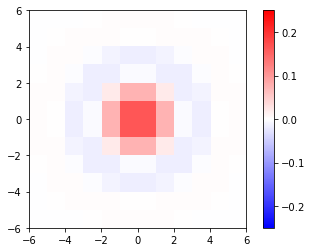

Frequency response:


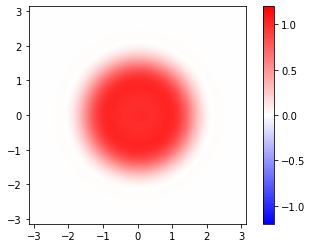

Odd size kernel:
Kernel:


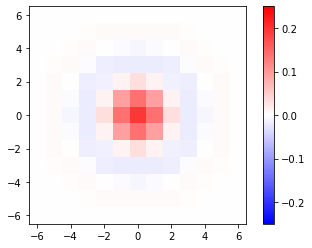

Frequency response:


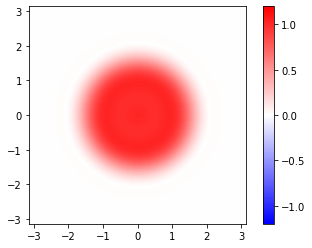

<ShuffleDataset shapes: (), types: tf.string>
Batch size = 36


In [38]:
# Configuration
oversampling = 2  # Oversampling factor, 2 is a good choice
aa_even_kernel_size = 12 # Size of even sized antialiasing filter
aa_odd_kernel_size = aa_even_kernel_size + 1 # Size of odd sized antialiasing filter
approx_batch_size = 36
train_image_cropped_size = 256
photos_dir = "C:/Users/romat/Desktop/somefolder"
save_filtered_photos_dir = "D:/roman/filtered_grass_images_subset" # save folder, or None to disable saving

print("Even size kernel:")
test_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_even_kernel_size))
print("Odd size kernel:")
test_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_odd_kernel_size))

def channeled_kernel(kernel_prototype, num_channels):
    kernel_expanded = tf.expand_dims(kernel_prototype, 2)
    kernel_repeated = tf.repeat(kernel_expanded, num_channels, axis=2)
    return tf.expand_dims(kernel_repeated, -1)

def load_and_filter_image(filepath, channeled_kernel):
    image = tf.io.decode_png(tf.io.read_file(filepath), channels=3, dtype=tf.dtypes.uint8)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) * 2 - 1
    image = tf.nn.depthwise_conv2d([image], channeled_kernel, [1, 1, 1, 1], "VALID")[0]
    if save_filtered_photos_dir is not None:
        basename = tf.py_function(lambda string_tensor: os.path.basename(string_tensor.numpy()), [filepath], tf.string)
        tf.io.write_file(save_filtered_photos_dir + "/" + basename, tf.io.encode_png(tf.image.convert_image_dtype((image + 1)/2, dtype=tf.dtypes.uint8, saturate=True)))
    return image

train_dataset = tf.data.Dataset.list_files("C:/Users/romat/Desktop/filtered/*.png")
print(train_dataset)
train_dataset = train_dataset.map(lambda filepath: load_and_filter_image(filepath, channeled_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_even_kernel_size), 3)), num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
train_dataset = train_dataset.cache() # Load photos now instead of doing it again for each copy made in the next line
train_dataset = train_dataset.repeat(tf.math.floordiv(approx_batch_size, train_dataset.cardinality()))
train_dataset = train_dataset.cache()

batch_size = train_dataset.cardinality() # batch size
print("Batch size = " + str(batch_size.numpy()))

## Isotropic lowpass filtering layers
These layers apply a circularly symmmetrical lowpass filter. They preserve spatial centering of the data to facilitate skip connections and center cropping in the network.

`IsotropicLowpassFilterLayer` accepts `strides = 1` to preserve the feature map size and `strides = 2` to downsample it to half size. With `strides = 1`, the kernel size must be odd. With downsampling, only even input and kernel sizes are supported, resulting in even-sized output. `cutoff` is the cutoff frequency (before downsampling).

`IsotropicLowpassFilteredUpsampleLayer` doubles the spatial size of the feature map. `cutoff` is the cutoff frequency after upsampling. `kernel_size` must be even.

Test input:
(15, 15, 3)
tf.Tensor(
[[[[1. 1. 1.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [1. 1. 1.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [1. 1. 1.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [1. 1. 1.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [1. 1. 1.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [1. 1. 1.]]]


 [[[1. 1. 1.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [1. 1. 1.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [1. 1. 1.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [1. 1. 1.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0

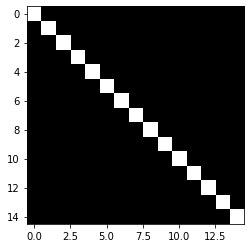

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Isotropic lowpass filtered:


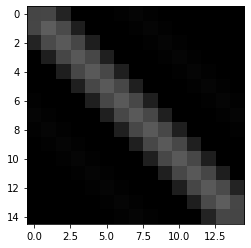

Isotropic lowpass filtered upsampled:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


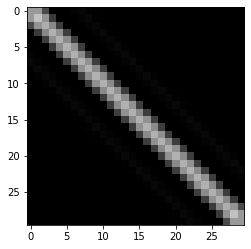

In [39]:
class IsotropicLowpassFilterLayer(tf.keras.layers.Layer):
    def __init__(self, cutoff, kernel_size, strides = 1):
        super(IsotropicLowpassFilterLayer, self).__init__()
        self.kernel_size = kernel_size
        self.strides = strides        
        assert self.strides == 1 or self.strides == 2, "Accepted values for strides are 1 and 2. Tuples or arrays are not accepted."
        if self.strides == 1:
            assert self.kernel_size % 2 == 1, "kernel_size must be odd when strides = 1"
        if self.strides == 2:
            assert self.kernel_size % 2 == 0, "kernel_size must be even when strides = 2"
        
        self.kernel_prototype = windowed_circular_lowpass_kernel(cutoff, self.kernel_size)
        
    def build(self, input_shape):
        self.filtering = tf.keras.layers.DepthwiseConv2D(self.kernel_size, trainable=False, use_bias=False, padding='same', strides=self.strides, weights=[channeled_kernel(self.kernel_prototype, input_shape[-1])])

    def call(self, inputs):
        return self.filtering(inputs)

def get_upsample_multiplication_tensor(input_shape):
    tile = tf.constant([[0, 0], [0, 4]], dtype=tf.float32)
    return tf.reshape(tf.tile(tile, [input_shape[-3], input_shape[-2]]), (1, input_shape[-3]*2, input_shape[-2]*2, 1))

class IsotropicLowpassFilteredUpsampleLayer(tf.keras.layers.Layer):
    def __init__(self, cutoff, kernel_size):
        super(IsotropicLowpassFilteredUpsampleLayer, self).__init__()
        self.kernel_size = kernel_size
        assert self.kernel_size % 2 == 0, "kernel_size must be even"
        self.upsampling = tf.keras.layers.UpSampling2D(size = (2, 2), interpolation='nearest')
        self.multiply = tf.keras.layers.Multiply()
        #self.zeropadding = tf.keras.layers.ZeroPadding2D(padding = ((0, 1), (0, 1)))  # not needed for input even -> output even
        self.kernel_prototype = windowed_circular_lowpass_kernel(cutoff, kernel_size)
        self.kernel_size = kernel_size
        
    def build(self, input_shape):
        self.multiplication_tensor = get_upsample_multiplication_tensor(input_shape)
        self.filtering = tf.keras.layers.DepthwiseConv2D(self.kernel_size, trainable=False, use_bias=False, padding='same', weights=[channeled_kernel(self.kernel_prototype, input_shape[-1])])

    def call(self, inputs):
        x = self.upsampling(inputs)
        x = self.multiply([x, self.multiplication_tensor])
        #x = self.zeropadding(x)  # not needed for input even -> output even
        x = self.filtering(x)
        return x    
    
print("Test input:")
input_shapes = (aa_odd_kernel_size + 2, aa_odd_kernel_size + 2, 3)
print(input_shapes)
eye = tf.repeat(tf.expand_dims(tf.repeat(tf.expand_dims(tf.eye(input_shapes[0], input_shapes[1]), -1), repeats = input_shapes[2], axis = -1), 0), repeats = batch_size, axis = 0)
print(eye)
plt.imshow(eye[0])
plt.show()

def TestModel(input_shapes):
    inputs = tf.keras.Input(input_shapes)
    outputs = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)    
    return model

print("Isotropic lowpass filtered:")
model = TestModel(input_shapes)
output = model(eye)
plt.imshow(output[0])
plt.show()

def TestModel(input_shapes):
    inputs = tf.keras.Input(input_shapes)
    outputs = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size)(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)    
    return model

print("Isotropic lowpass filtered upsampled:")
model = TestModel(input_shapes)
output = model(eye)
plt.imshow(output[0])
plt.show()

## Get a batch from the dataset by recropping photos
This should be done in the beginning of each epoch by calling RandomCropper.recrop()

First recrop, first item:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


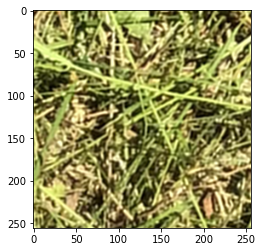

Second recrop, first item:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


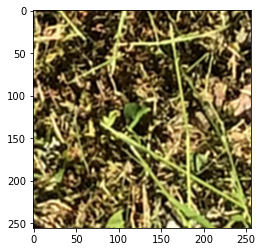

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Second recrop, second item:


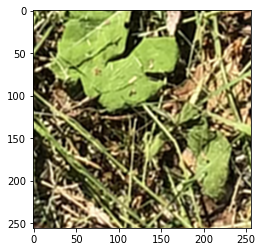

In [40]:
class RandomCropper:
    def __init__(self, dataset, first_seed = None):
        if first_seed is None:
            first_seed = int(str(int((datetime.utcnow() - datetime(1970, 1, 1)).total_seconds()*1_000_000))[::-1][:16])
        self.dataset_seeded = dataset.enumerate(first_seed)
    
    def recrop(self, size):
        cropped_dataset = self.dataset_seeded.map(lambda seed, image: tf.image.stateless_random_crop(image, (size, size, 3), [seed, 0]), num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
        self.dataset_seeded = self.dataset_seeded.map(lambda seed, image: (seed + self.dataset_seeded.cardinality(), image), num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
        return cropped_dataset
    
train_dataset_cropper = RandomCropper(train_dataset)
print("First recrop, first item:")
iterator = iter(train_dataset_cropper.recrop(train_image_cropped_size))
plt.imshow((next(iterator) + 1)/2)
plt.show()
print("Second recrop, first item:")
iterator = iter(train_dataset_cropper.recrop(train_image_cropped_size))
plt.imshow((next(iterator) + 1)/2)
plt.show()
print("Second recrop, second item:")
plt.imshow((next(iterator) + 1)/2)
plt.show()

## Generator model
Define the generator network, parameterized by input image size.

[-0.98788065 -0.6819107  -0.9536234 ]
[0.9777863 1.0206391 1.0002685]


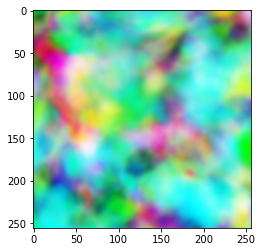

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


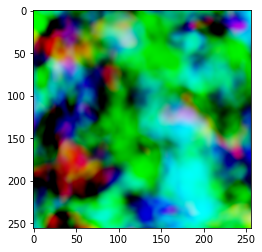

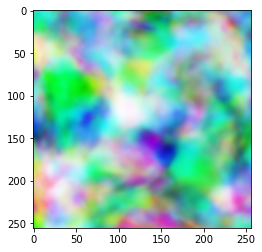

In [41]:
def Generator(input_size, nonlinearity, initializer):      
    inputs = tf.keras.Input(shape = (input_size, input_size, 1), name = "input")
  
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(inputs)
  
    #-----------------First down

    x = tf.keras.layers.Conv2D(32, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    x = tf.keras.layers.Conv2D(32, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_even_kernel_size, strides=2)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)

    #-----------------Second down

    x = tf.keras.layers.Conv2D(64, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    x = tf.keras.layers.Conv2D(64, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_even_kernel_size, strides=2)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    
    #-----------------Third down

    x = tf.keras.layers.Conv2D(128, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    x = tf.keras.layers.Conv2D(128, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_even_kernel_size, strides=2)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)

    #----------------- Fourth down

    x = tf.keras.layers.Conv2D(256, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    x = tf.keras.layers.Conv2D(256, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_even_kernel_size, strides=2)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)

    #----------------- Fifth down

    x = tf.keras.layers.Conv2D(512, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    x = tf.keras.layers.Conv2D(512, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_even_kernel_size, strides=2)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)

    #----------------- Fifth last up

    x = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size)(x)
    x = tf.keras.layers.Conv2D(512, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    x = tf.keras.layers.Conv2D(512, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)    

    #----------------- Fourth last up

    x = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size)(x)
    x = tf.keras.layers.Conv2D(256, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    x = tf.keras.layers.Conv2D(256, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)    
    
    #----------------- Third last up

    x = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size)(x)
    x = tf.keras.layers.Conv2D(128, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    x = tf.keras.layers.Conv2D(128, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)    
    
    #----------------- Second last up

    x = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size)(x)
    x = tf.keras.layers.Conv2D(64, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    x = tf.keras.layers.Conv2D(64, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)

    #-----------------Last up

    x = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size)(x)
    x = tf.keras.layers.Conv2D(32, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.Activation(nonlinearity)(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    x = tf.keras.layers.Conv2D(3, 5, kernel_initializer=initializer, use_bias=True, padding="same")(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(x)
    
    # Crop the center
    
    x = tf.keras.layers.CenterCrop(input_size//2, input_size//2)(x)

    return  tf.keras.Model(inputs=inputs, outputs=x)

input_size = train_image_cropped_size*2

initializer = tf.keras.initializers.RandomUniform(-0.1, 0.1)
generator = Generator(input_size, "relu", "glorot_uniform")
generator.build((4, input_size, input_size, 1))

# Generate, normalize for display, again
generator_output = generator(tf.random.uniform((4, input_size, input_size, 1), minval=0, maxval=None), training = True)[0].numpy()
print(np.amin(generator_output, axis = (0, 1)))
print(np.amax(generator_output, axis = (0, 1)))
generator_output -= np.amin(generator_output, axis = (0, 1))
generator_output /= np.amax(generator_output, axis = (0, 1))
plt.imshow(generator_output)
plt.show()

# Generate, display
generator_output = generator(tf.random.uniform((4, input_size, input_size, 1), minval=0, maxval=None), training = True)[0].numpy()
plt.imshow(generator_output)
plt.show()

# Generate, normalize for display, again
generator_output = generator(tf.random.uniform((4, input_size, input_size, 1), minval=0, maxval=None), training = True)[0].numpy()
generator_output -= np.amin(generator_output, axis = (0, 1))
generator_output /= np.amax(generator_output, axis = (0, 1))
plt.imshow(generator_output)
plt.show()